<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [138]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from collections import OrderedDict
from typing import Union, List

import torch
import torch.nn as nn

from tqdm.auto import trange
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, EvalPrediction
from transformers.modeling_outputs import SequenceClassifierOutput

import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], fc_size, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.fc_size = fc_size
        self.backbone = AutoModel.from_pretrained(base_transformer_model) if isinstance(base_transformer_model, str) else base_transformer_model
        # YOUR CODE: create additional layers for classfication
        self.fc = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(self.backbone.config.hidden_size, self.fc_size)),
            ('ReLU', nn.ReLU()),
            ('lin2', nn.Linear(self.fc_size, self.num_classes))
            ])
        )
        self.config = self.backbone.config
        self.loss = nn.CrossEntropyLoss()

    def forward(self, 
                inputs, 
                attention_mask=None, 
                labels=None,
                output_attentions=False
                ): 
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        # print(attention_mask)
        outputs_backbone = self.backbone(input_ids=inputs, 
                                         attention_mask=attention_mask, 
                                         output_attentions=output_attentions)
        
        
        logits = self.fc(outputs_backbone['pooler_output'])
        loss=None
        attentions=None
        if not labels is None:
            loss = self.loss(logits, labels)
        if output_attentions:
            attentions = outputs_backbone['attentions']
        return SequenceClassifierOutput(loss=loss, 
                                       logits=logits,
                                       attentions=attentions)
    

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [112]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for name, param in model.named_parameters():
        if 'backbone' in name:
            param.requires_grad = False

### Чтение и подгтовка данных

In [4]:
russian_data = pd.read_excel('data_problems.xlsx', index_col=0)
english_data = pd.read_excel('data_problems_translated.xlsx', index_col=0)

english_data['problem_text'] = english_data['problem_text'].astype(str)

In [67]:
class DataForClassification(Dataset):
    def __init__(self, data, tokenizer, task_column='Задача', class_column='Тема', max_len=None):
        self.tasks = data[task_column].values
        self.labels = data[class_column].values
        self.tokenizer = tokenizer
        self.matching = {v : i for i, v in enumerate(sorted(data[class_column].unique()))}
        self.max_len = max_len

    def __getitem__(self, idx):
        tokenized_sentence = self.tokenizer.encode(self.tasks[idx], max_length=self.max_len)
        return {'inputs' : torch.tensor(tokenized_sentence, dtype=torch.int32), 
                'label' : self.matching[self.labels[idx]]}
    
    def __len__(self):
        return len(self.labels)

In [118]:
def collate_fn_with_pad(batch: list[dict[str, torch.Tensor]], pad_idx=0):
    max_len = 0
    for b in batch:
        max_len = max(max_len, b['inputs'].shape[0])
    new_seq = []
    labels = []
    for b in batch:
        labels.append(b['label'])
        
        pad_tensor = torch.full([max_len - b['inputs'].shape[0]], pad_idx)
        new_seq.append(torch.cat([b['inputs'], pad_tensor]))
    input_ids = torch.stack(new_seq)
    attention_mask = (input_ids != pad_idx).to(torch.int32)
    return {'inputs' : input_ids, 'labels' : torch.tensor(labels, dtype=torch.long), 'attention_mask':attention_mask}

In [10]:
#train_dataloader = DataLoader(dataset_train, batch_size=16, collate_fn=collate_fn_with_pad)
#validate_dataloader = DataLoader(dataset_validation, batch_size=16, collate_fn=collate_fn_with_pad)

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [28]:
def compute_metrics(data: EvalPrediction):
    model_preds = np.argmax(data.predictions, axis=-1)
    
    return {
        'f1_score' : f1_score(data.label_ids, model_preds, average='weighted'),
        'accuracy': (model_preds == data.label_ids).sum() / len(model_preds)}

In [58]:
a.config.max_position_embeddings

2048

In [82]:
def train_transformer(model, tokenizer, data, freeze_backbone, language='russian', lr=1e-5):
    task_column = 'Задача'
    class_column = 'Тема'

    if language != 'russian':
        task_column = 'problem_text'
        class_column = 'topic'

    train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data[class_column])

    dataset_train = DataForClassification(train_data, tokenizer, task_column, class_column, max_len=model.config.max_position_embeddings)
    dataset_validation = DataForClassification(validation_data, tokenizer, task_column, class_column, max_len=model.config.max_position_embeddings)

    if freeze_backbone:
        freeze_backbone_function(model)
    trainable_params = sum(torch.numel(param) if param.requires_grad else 0 for param in model.parameters() )
    print(trainable_params, 'number of trainable params')
    training_config = TrainingArguments('model_training',
                                        overwrite_output_dir=True,
                                        do_train=True,
                                        do_eval=True,
                                        eval_strategy='epoch',
                                        #learning_rate=lr,
                                        save_safetensors=False,
                                        disable_tqdm=True
                                    )

    trainer = Trainer(model=model,
                      args=training_config,
                      data_collator=collate_fn_with_pad, 
                      train_dataset=dataset_train,
                      eval_dataset=dataset_validation,
                      compute_metrics=compute_metrics
                  )
    
    trainer.train()

In [238]:
rubert_tiny_transformer_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.48.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 83828
}

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [123]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', 1000, 7)
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

train_transformer(rubert_tiny_transformer_model, tokenizer, russian_data, freeze_backbone=True, language='russian', lr=1e-4)

320007 number of trainable params


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'loss': 1.6025, 'grad_norm': 1.3085858821868896, 'learning_rate': 3.421717171717172e-05, 'epoch': 0.946969696969697}
{'eval_loss': 1.4463461637496948, 'eval_f1_score': 0.32926438091665644, 'eval_accuracy': 0.4663507109004739, 'eval_runtime': 0.8704, 'eval_samples_per_second': 1212.14, 'eval_steps_per_second': 151.661, 'epoch': 1.0}
{'loss': 1.4054, 'grad_norm': 1.021525502204895, 'learning_rate': 1.8434343434343433e-05, 'epoch': 1.893939393939394}
{'eval_loss': 1.3510695695877075, 'eval_f1_score': 0.40815290139311095, 'eval_accuracy': 0.5213270142180095, 'eval_runtime': 0.8767, 'eval_samples_per_second': 1203.418, 'eval_steps_per_second': 150.57, 'epoch': 2.0}
{'loss': 1.34, 'grad_norm': 1.0038758516311646, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.840909090909091}
{'eval_loss': 1.326054334640503, 'eval_f1_score': 0.41490916683393, 'eval_accuracy': 0.5260663507109005, 'eval_runtime': 0.8797, 'eval_samples_per_second': 1199.338, 'eval_steps_per_second': 150.059, 'epoch': 3.0}


In [219]:
rubert_tiny_transformer_model_no_freeze = TransformerClassificationModel('cointegrated/rubert-tiny2', 1000, 7)
train_transformer(rubert_tiny_transformer_model_no_freeze, tokenizer, russian_data, freeze_backbone=False, language='russian')

29513775 number of trainable params


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'loss': 1.4332, 'grad_norm': 5.567917346954346, 'learning_rate': 3.421717171717172e-05, 'epoch': 0.946969696969697}
{'eval_loss': 1.2185341119766235, 'eval_f1_score': 0.46100441725687746, 'eval_accuracy': 0.5497630331753555, 'eval_runtime': 3.6191, 'eval_samples_per_second': 291.51, 'eval_steps_per_second': 36.473, 'epoch': 1.0}
{'loss': 1.1627, 'grad_norm': 21.532360076904297, 'learning_rate': 1.8434343434343433e-05, 'epoch': 1.893939393939394}
{'eval_loss': 1.1466175317764282, 'eval_f1_score': 0.5280924403819931, 'eval_accuracy': 0.5838862559241706, 'eval_runtime': 3.5965, 'eval_samples_per_second': 293.344, 'eval_steps_per_second': 36.703, 'epoch': 2.0}
{'loss': 1.0719, 'grad_norm': 5.08303689956665, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.840909090909091}
{'eval_loss': 1.1222059726715088, 'eval_f1_score': 0.5271204101611634, 'eval_accuracy': 0.5876777251184834, 'eval_runtime': 3.5966, 'eval_samples_per_second': 293.333, 'eval_steps_per_second': 36.701, 'epoch': 3.0}
{'t

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [134]:
math_bert_freezed = TransformerClassificationModel('tbs17/MathBert', 1000, 7)
tokenizer = AutoTokenizer.from_pretrained('tbs17/MathBert')

train_transformer(math_bert_freezed, tokenizer, english_data, freeze_backbone=True, language='english', lr=5e-4)

776007 number of trainable params


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'loss': 1.5088, 'grad_norm': 2.5942776203155518, 'learning_rate': 3.421717171717172e-05, 'epoch': 0.946969696969697}
{'eval_loss': 1.4112720489501953, 'eval_f1_score': 0.35315308143394214, 'eval_accuracy': 0.46729857819905213, 'eval_runtime': 3.6024, 'eval_samples_per_second': 292.859, 'eval_steps_per_second': 36.642, 'epoch': 1.0}
{'loss': 1.3937, 'grad_norm': 2.6299216747283936, 'learning_rate': 1.8434343434343433e-05, 'epoch': 1.893939393939394}
{'eval_loss': 1.3503628969192505, 'eval_f1_score': 0.36419350691485136, 'eval_accuracy': 0.4928909952606635, 'eval_runtime': 3.6474, 'eval_samples_per_second': 289.248, 'eval_steps_per_second': 36.19, 'epoch': 2.0}
{'loss': 1.3295, 'grad_norm': 4.122648239135742, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.840909090909091}
{'eval_loss': 1.3180238008499146, 'eval_f1_score': 0.39309602185003506, 'eval_accuracy': 0.5033175355450237, 'eval_runtime': 3.6272, 'eval_samples_per_second': 290.857, 'eval_steps_per_second': 36.392, 'epoch': 3.0

In [135]:
math_bert_not_freezed = TransformerClassificationModel('tbs17/MathBert', 1000, 7)
train_transformer(math_bert_not_freezed, tokenizer, english_data, freeze_backbone=False, language='english', lr=1e-5)

110258247 number of trainable params
{'loss': 1.1997, 'grad_norm': 5.740862846374512, 'learning_rate': 3.421717171717172e-05, 'epoch': 0.946969696969697}
{'eval_loss': 1.0380042791366577, 'eval_f1_score': 0.5794341475136893, 'eval_accuracy': 0.6180094786729858, 'eval_runtime': 3.6662, 'eval_samples_per_second': 287.76, 'eval_steps_per_second': 36.004, 'epoch': 1.0}
{'loss': 0.9169, 'grad_norm': 10.81688404083252, 'learning_rate': 1.8434343434343433e-05, 'epoch': 1.893939393939394}
{'eval_loss': 0.962092936038971, 'eval_f1_score': 0.5828906811350623, 'eval_accuracy': 0.6407582938388625, 'eval_runtime': 3.748, 'eval_samples_per_second': 281.483, 'eval_steps_per_second': 35.219, 'epoch': 2.0}
{'loss': 0.7002, 'grad_norm': 4.854081630706787, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.840909090909091}
{'eval_loss': 0.9771847724914551, 'eval_f1_score': 0.6182013021934347, 'eval_accuracy': 0.6369668246445498, 'eval_runtime': 3.6482, 'eval_samples_per_second': 289.18, 'eval_steps_per_s

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [393]:
def draw_first_layer_attention_maps(attention_head_ids: List[int],
                                    model: TransformerClassificationModel, 
                                    input_ids, 
                                    tokenizer, 
                                    title):
    attentions = model.forward(example, output_attentions=True)['attentions'][0].squeeze(0)
    fig, axs = plt.subplots(1, len(attention_head_ids), figsize=(15, 3))
    # axs.set_title(title)
    fig.suptitle(title)
    for i, idx in enumerate(attention_head_ids):
        ax = axs[i]
        sns.heatmap(attentions[idx].cpu().detach(), cmap='viridis', ax=ax, cbar=False)
        ax.set_title(f"Голова {idx+1}")
        # Метки токенов
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90)
        ax.set_yticklabels(tokens, rotation=0)

    plt.tight_layout()
    plt.show()

In [ ]:
tokenizer_rus = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
dataset_for_heatmap_russian = DataForClassification(russian_data, tokenizer_rus)


tokenizer_engl = AutoTokenizer.from_pretrained('tbs17/MathBert')
dataset_for_heatmap_engl = DataForClassification(english_data, tokenizer_engl, task_column='problem_text', class_column='topic', max_len=512)

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [382]:
### YOUR CODE IS HERE
russian_bert = TransformerClassificationModel('cointegrated/rubert-tiny2', 1000, 7).to('cuda')
english_bert = TransformerClassificationModel('tbs17/MathBert', 1000, 7).to('cuda')

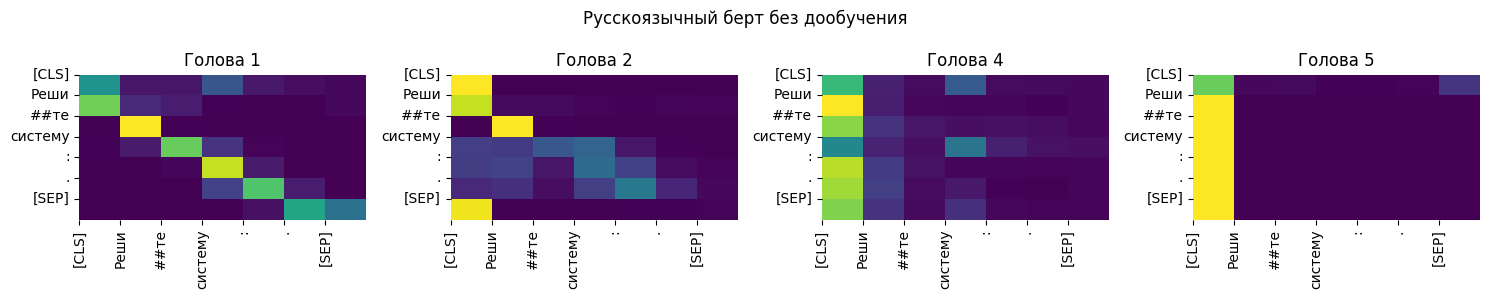

In [394]:
idx_example = 845

example = dataset_for_heatmap_russian[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 3, 4], russian_bert, example, tokenizer_rus, title='Русскоязычный берт без дообучения')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

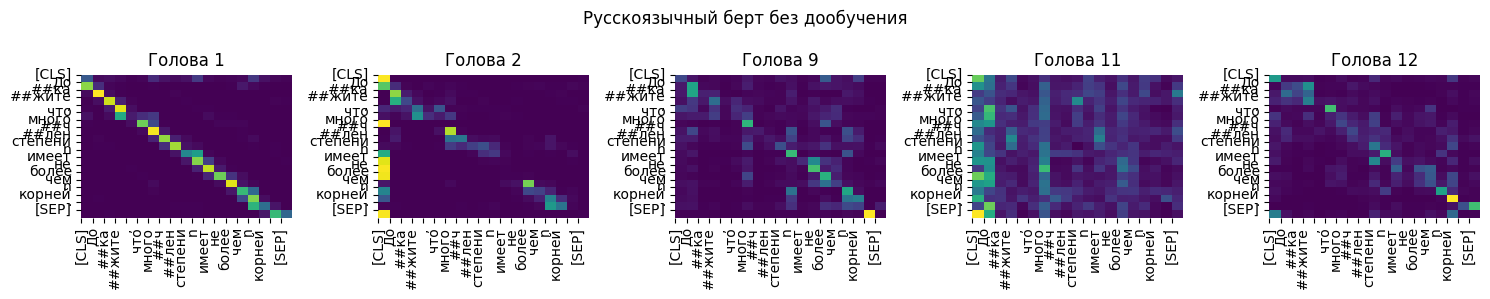

In [398]:
idx_example = 794

example = dataset_for_heatmap_russian[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], russian_bert, example, tokenizer_rus, title='Русскоязычный берт без дообучения')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

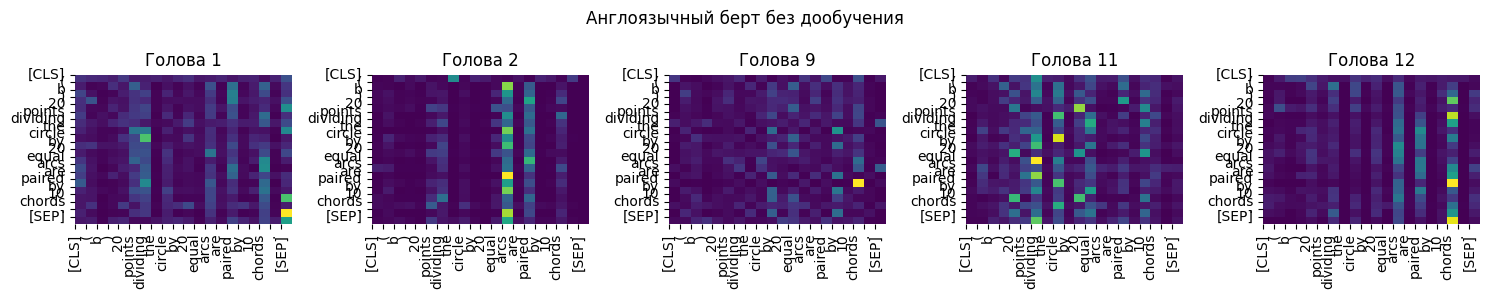

In [405]:
idx_example = 898

example = dataset_for_heatmap_engl[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], english_bert, example, tokenizer_engl, title='Англоязычный берт без дообучения')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

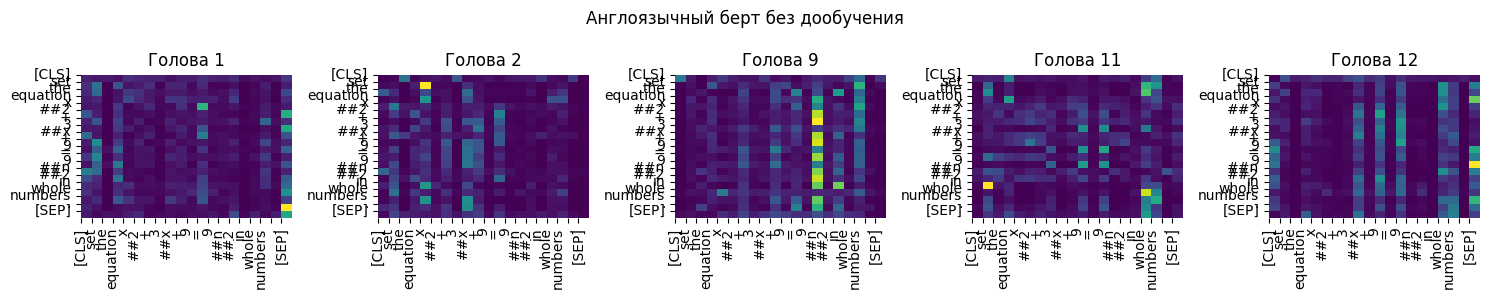

In [406]:
idx_example = 877

example = dataset_for_heatmap_engl[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], english_bert, example, tokenizer_engl, title='Англоязычный берт без дообучения')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

In [ ]:
# Мы наблюдаем, что каждая голова отвечает за какую-то определенную связь: 
Одна из голов улавливает связь соседних токенов, одна из голов улавливает связь первого токена со всеми остальными, другая смотрит

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

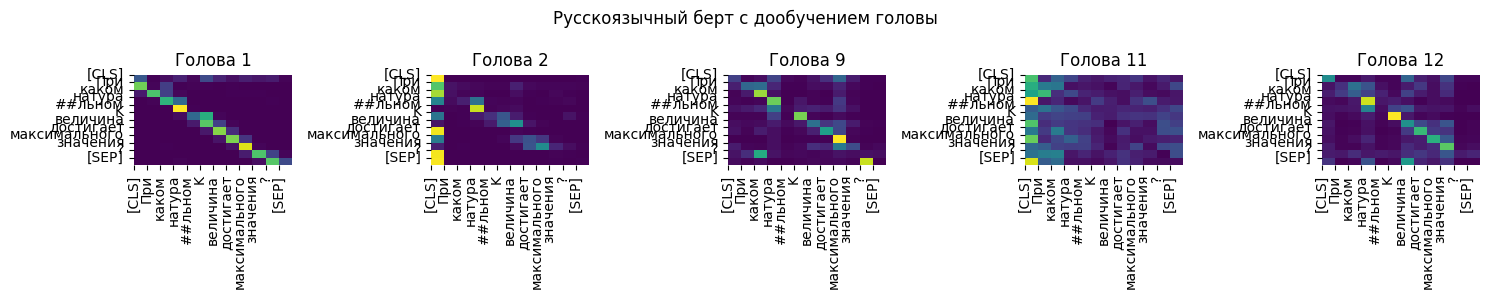

In [407]:
idx_example = 855

example = dataset_for_heatmap_russian[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], rubert_tiny_transformer_model, example, tokenizer_rus, title='Русскоязычный берт с дообучением головы')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

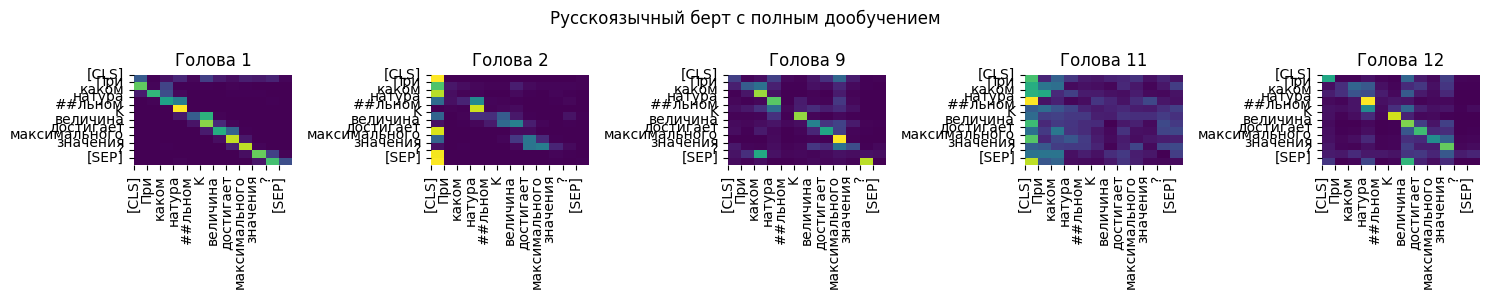

In [408]:
idx_example = 855

example = dataset_for_heatmap_russian[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], rubert_tiny_transformer_model_no_freeze, example, tokenizer_rus, title='Русскоязычный берт c полным дообучением')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

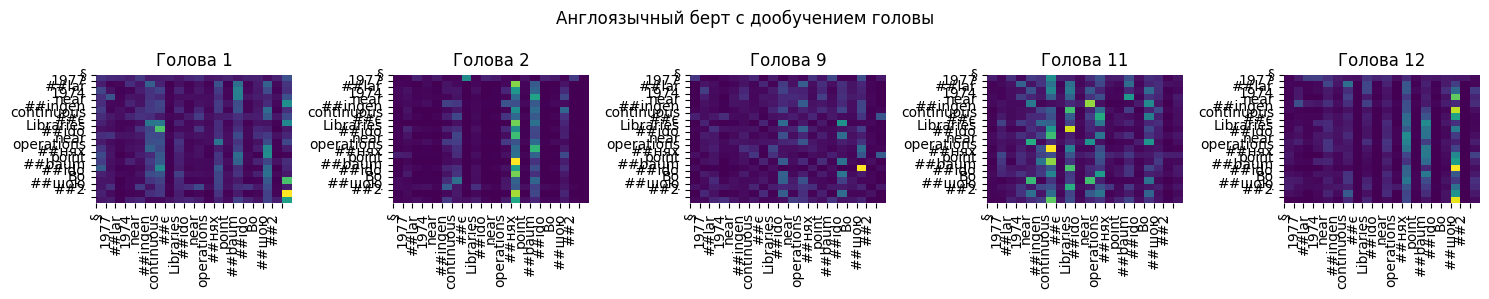

In [409]:
idx_example = 898

example = dataset_for_heatmap_engl[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], math_bert_freezed, example, tokenizer_rus, title='Англоязычный берт с дообучением головы')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

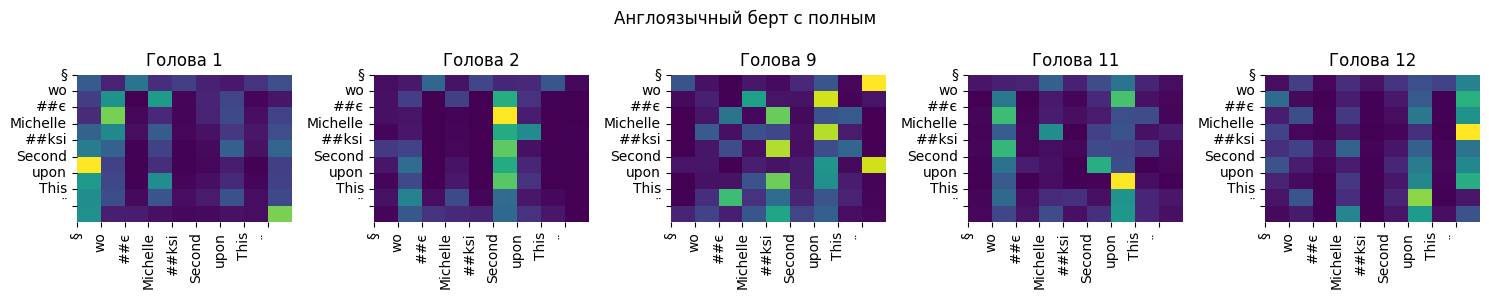

In [ ]:
idx_example = 503

example = dataset_for_heatmap_engl[idx_example]['inputs'].unsqueeze(0).to('cuda')
draw_first_layer_attention_maps([0, 1, 8, 10, 11], math_bert_not_freezed, example, tokenizer_rus, title='Англоязычный берт с полным')
# attention_mean = attention_mean.mean(axis=0).cpu().detach()

Видно, что маски внимания немного меняются, слова, связанные с математикой становится более важными. Что логично. Это произошло, потому что модели научились искать связи внутри корпуса задач, то есть смотреть на задачу с математической точки зрения.